# Cardiovascular Disease Prediction - EDA and Model Training

This notebook contains:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Model Training and Evaluation
4. Model Saving using cloudpickle

## Import Libraries

In [29]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model serialization
import cloudpickle
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## Data Loading and Basic Information

In [30]:
# Load the dataset
df = pd.read_csv('Data/cardio_train.csv', sep=';')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (70000, 13)

First 5 rows:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [31]:
# Dataset info
print("Dataset Info:")
df.info()

print("\nSummary Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB

Summary Statistics:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")

Missing Values:
Series([], dtype: int64)
No missing values found!


In [33]:
# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Target variable distribution
print("\nTarget Variable Distribution:")
print(df['cardio'].value_counts())
print("\nTarget Variable Percentage:")
print(df['cardio'].value_counts(normalize=True) * 100)

Number of duplicate rows: 0

Target Variable Distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64

Target Variable Percentage:
cardio
0    50.03
1    49.97
Name: proportion, dtype: float64


## Data Preprocessing

In [34]:
# Create a copy for preprocessing
df_processed = df.copy()

# Convert age from days to years
df_processed['age_years'] = df_processed['age'] // 365

# Calculate BMI
df_processed['bmi'] = df_processed['weight'] / ((df_processed['height'] / 100) ** 2)

# Create age groups
df_processed['age_group'] = pd.cut(df_processed['age_years'], 
                                   bins=[0, 40, 50, 60, 100], 
                                   labels=['<40', '40-50', '50-60', '60+'])

# Create BMI categories
df_processed['bmi_category'] = pd.cut(df_processed['bmi'], 
                                      bins=[0, 18.5, 25, 30, 100], 
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

print("Processed dataset shape:", df_processed.shape)
df_processed.head()

Processed dataset shape: (70000, 17)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,age_group,bmi_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,40-50,Normal
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,50-60,Obese
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,50-60,Normal
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,40-50,Overweight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,40-50,Normal


## Exploratory Data Analysis (EDA)

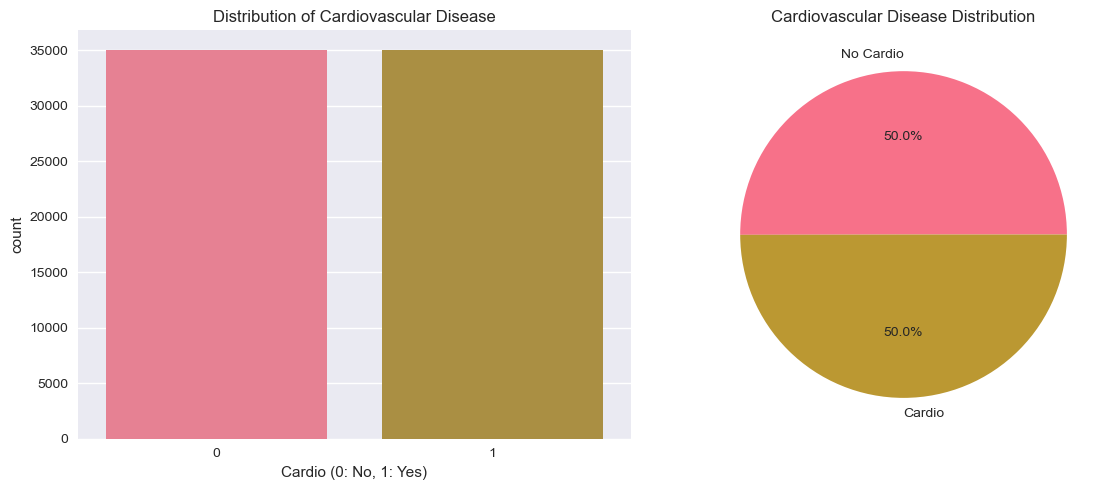

In [35]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=df_processed, x='cardio', ax=axes[0])
axes[0].set_title('Distribution of Cardiovascular Disease')
axes[0].set_xlabel('Cardio (0: No, 1: Yes)')

# Pie chart
cardio_counts = df_processed['cardio'].value_counts()
axes[1].pie(cardio_counts.values, labels=['No Cardio', 'Cardio'], autopct='%1.1f%%')
axes[1].set_title('Cardiovascular Disease Distribution')

plt.tight_layout()
plt.show()

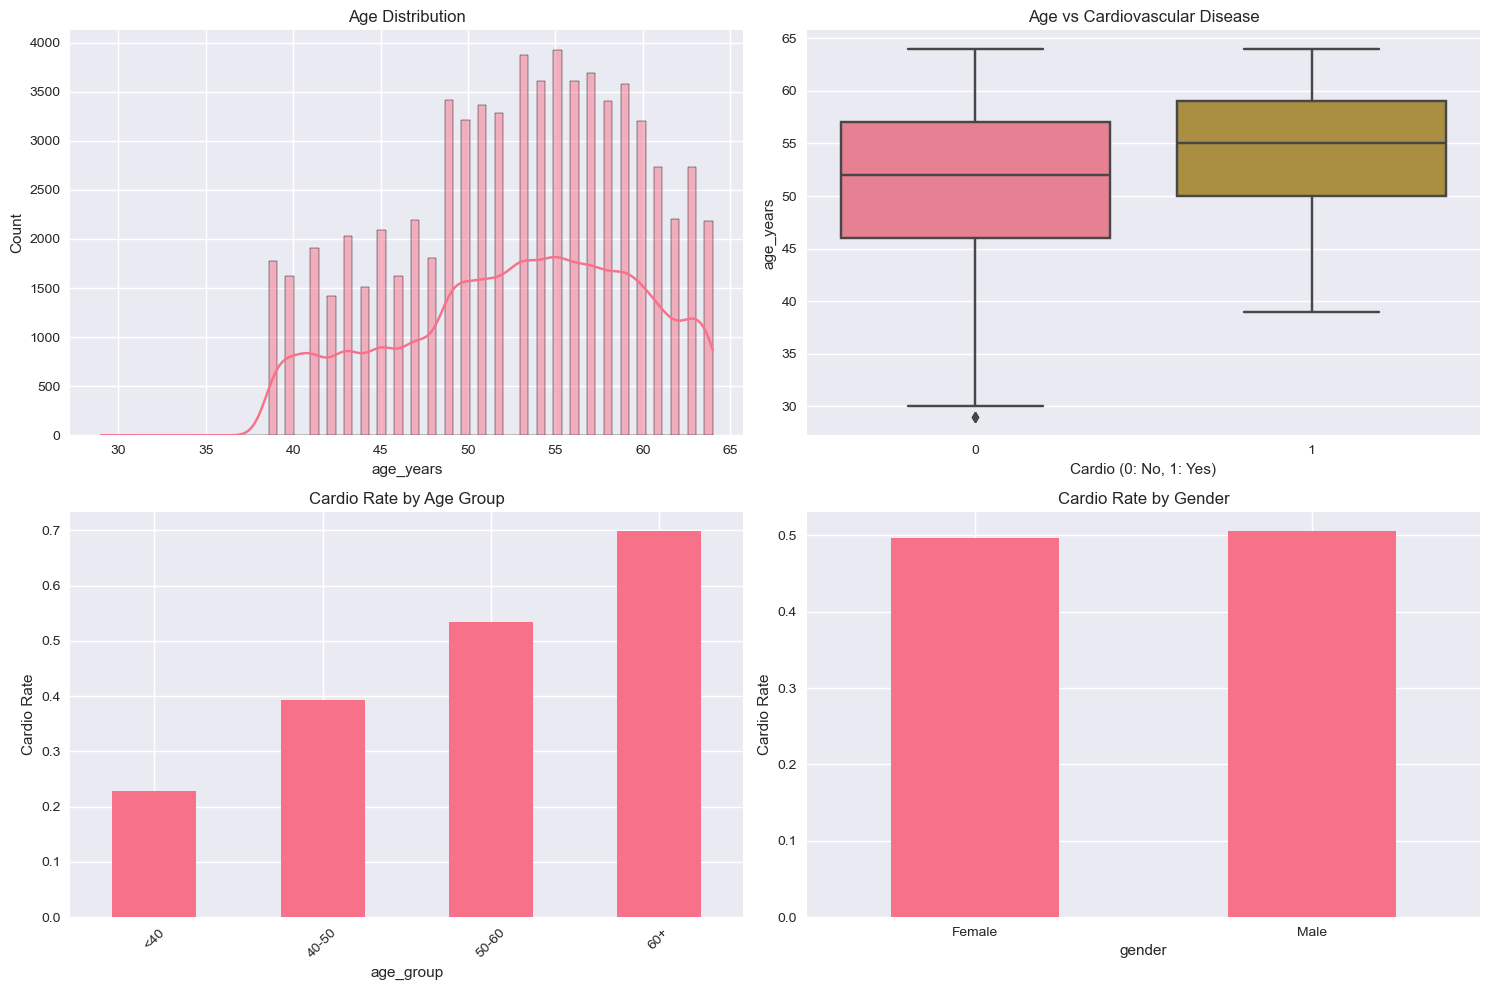

In [36]:
# Age distribution and its relationship with cardio
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
sns.histplot(data=df_processed, x='age_years', kde=True, ax=axes[0,0])
axes[0,0].set_title('Age Distribution')

# Age vs Cardio
sns.boxplot(data=df_processed, x='cardio', y='age_years', ax=axes[0,1])
axes[0,1].set_title('Age vs Cardiovascular Disease')
axes[0,1].set_xlabel('Cardio (0: No, 1: Yes)')

# Age group vs Cardio
cardio_by_age = df_processed.groupby('age_group')['cardio'].mean()
cardio_by_age.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Cardio Rate by Age Group')
axes[1,0].set_ylabel('Cardio Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# Gender vs Cardio
gender_cardio = df_processed.groupby('gender')['cardio'].mean()
gender_cardio.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Cardio Rate by Gender')
axes[1,1].set_ylabel('Cardio Rate')
axes[1,1].set_xticks([0, 1])
axes[1,1].set_xticklabels(['Female', 'Male'], rotation=0)

plt.tight_layout()
plt.show()

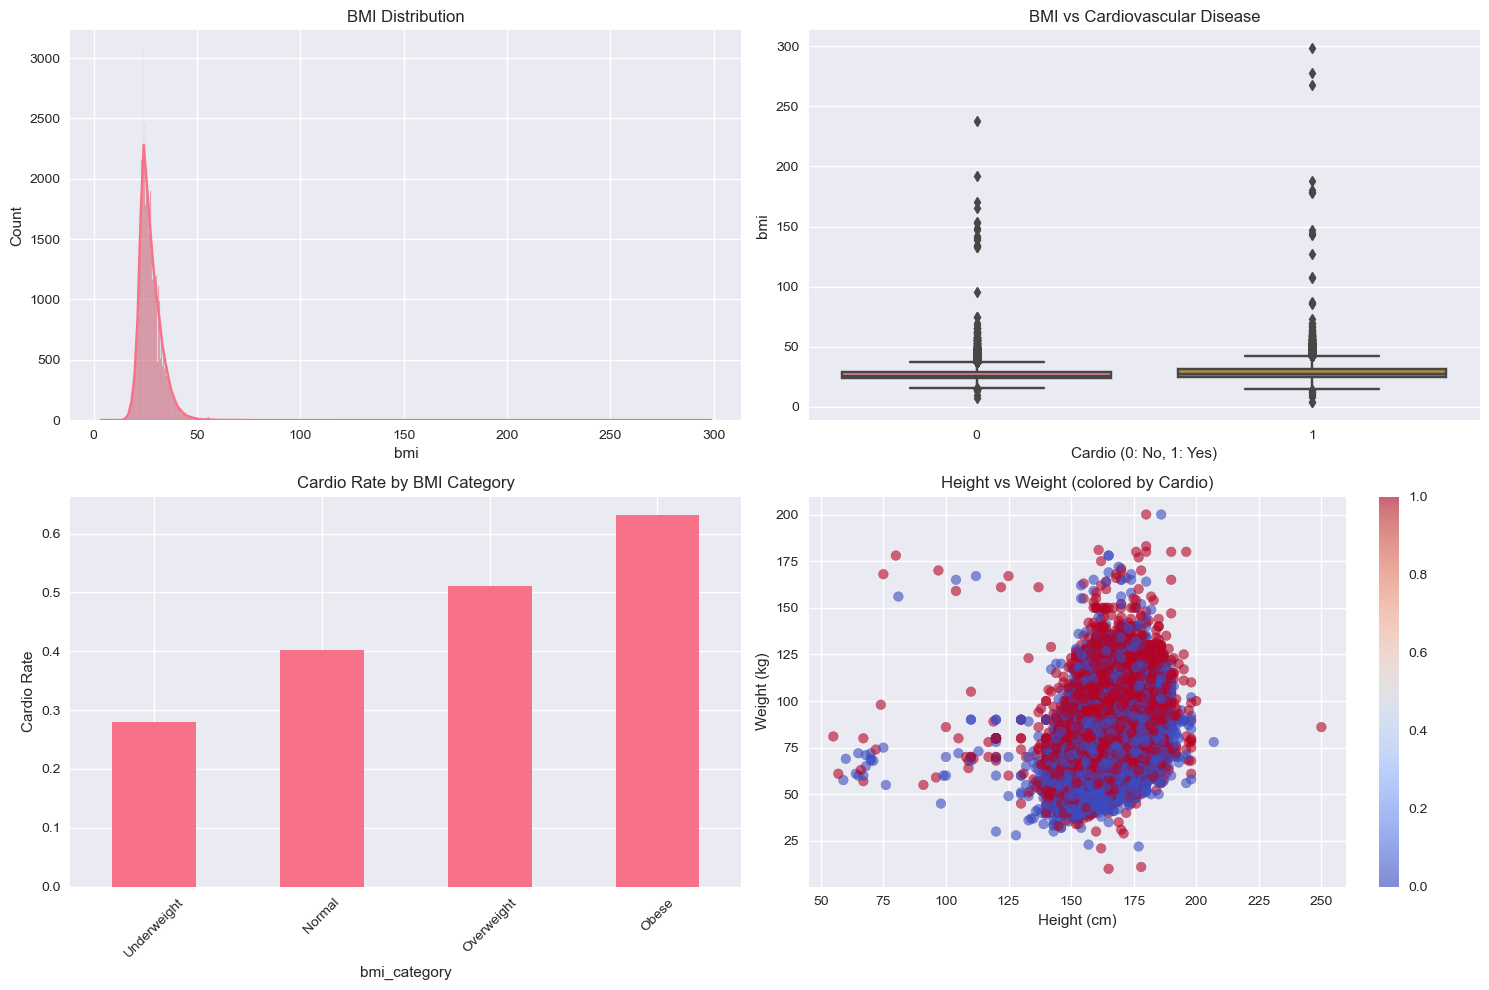

In [37]:
# BMI analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# BMI distribution
sns.histplot(data=df_processed, x='bmi', kde=True, ax=axes[0,0])
axes[0,0].set_title('BMI Distribution')

# BMI vs Cardio
sns.boxplot(data=df_processed, x='cardio', y='bmi', ax=axes[0,1])
axes[0,1].set_title('BMI vs Cardiovascular Disease')
axes[0,1].set_xlabel('Cardio (0: No, 1: Yes)')

# BMI category vs Cardio
bmi_cardio = df_processed.groupby('bmi_category')['cardio'].mean()
bmi_cardio.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Cardio Rate by BMI Category')
axes[1,0].set_ylabel('Cardio Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# Height vs Weight scatter
scatter = axes[1,1].scatter(df_processed['height'], df_processed['weight'], 
                           c=df_processed['cardio'], alpha=0.6, cmap='coolwarm')
axes[1,1].set_title('Height vs Weight (colored by Cardio)')
axes[1,1].set_xlabel('Height (cm)')
axes[1,1].set_ylabel('Weight (kg)')
plt.colorbar(scatter, ax=axes[1,1])

plt.tight_layout()
plt.show()

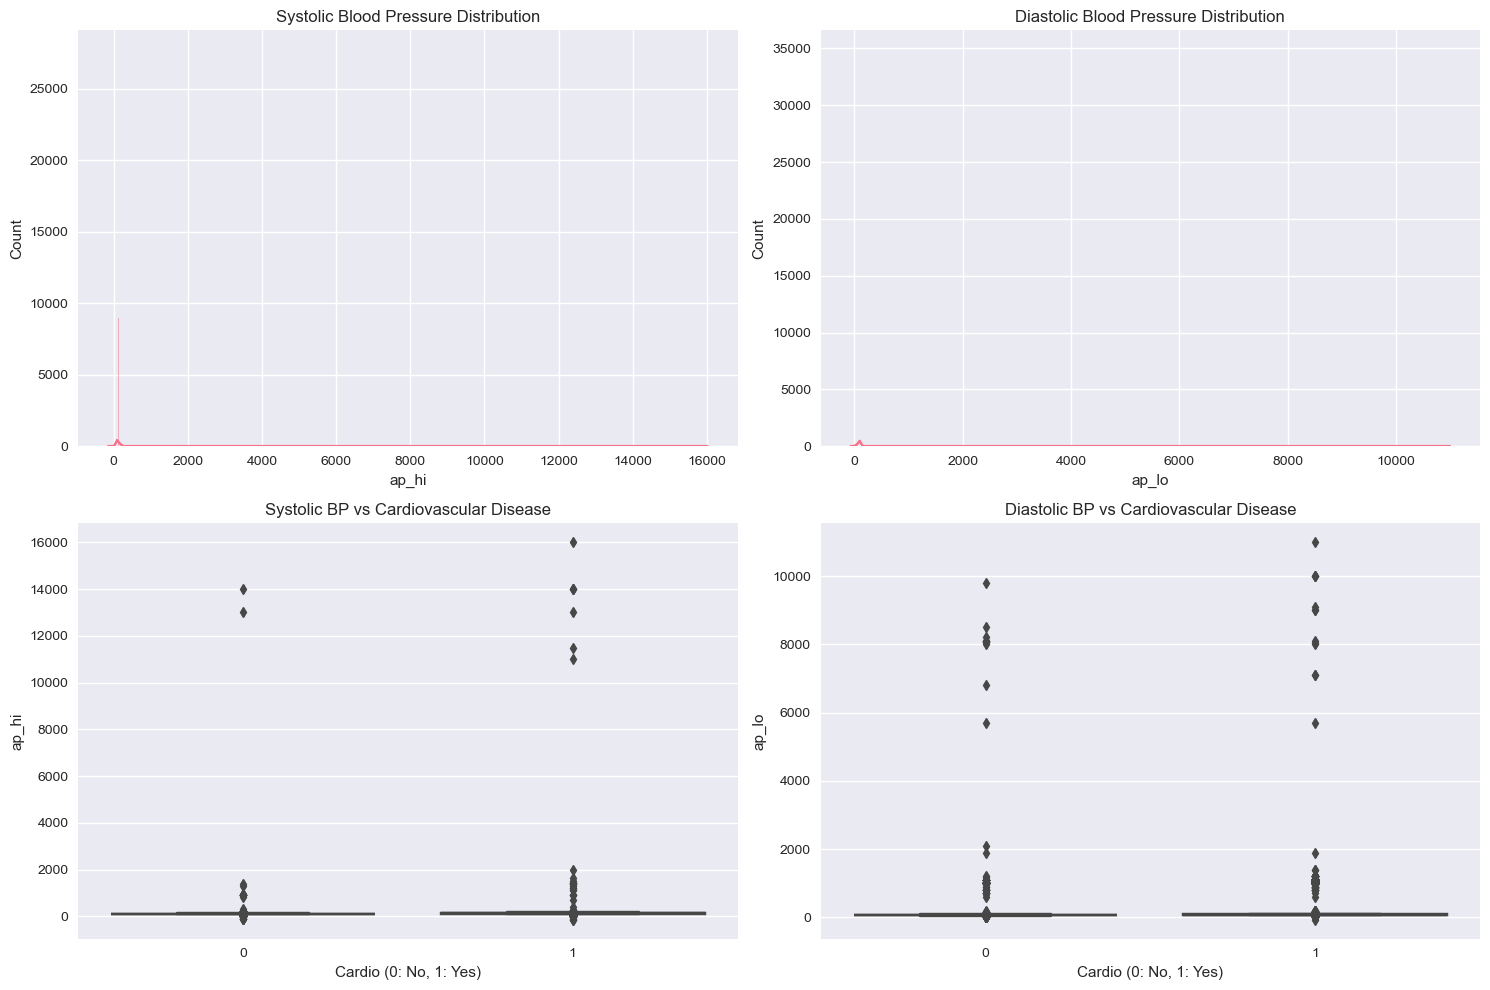

In [38]:
# Blood pressure analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Systolic BP distribution
sns.histplot(data=df_processed, x='ap_hi', kde=True, ax=axes[0,0])
axes[0,0].set_title('Systolic Blood Pressure Distribution')

# Diastolic BP distribution
sns.histplot(data=df_processed, x='ap_lo', kde=True, ax=axes[0,1])
axes[0,1].set_title('Diastolic Blood Pressure Distribution')

# Systolic BP vs Cardio
sns.boxplot(data=df_processed, x='cardio', y='ap_hi', ax=axes[1,0])
axes[1,0].set_title('Systolic BP vs Cardiovascular Disease')
axes[1,0].set_xlabel('Cardio (0: No, 1: Yes)')

# Diastolic BP vs Cardio
sns.boxplot(data=df_processed, x='cardio', y='ap_lo', ax=axes[1,1])
axes[1,1].set_title('Diastolic BP vs Cardiovascular Disease')
axes[1,1].set_xlabel('Cardio (0: No, 1: Yes)')

plt.tight_layout()
plt.show()

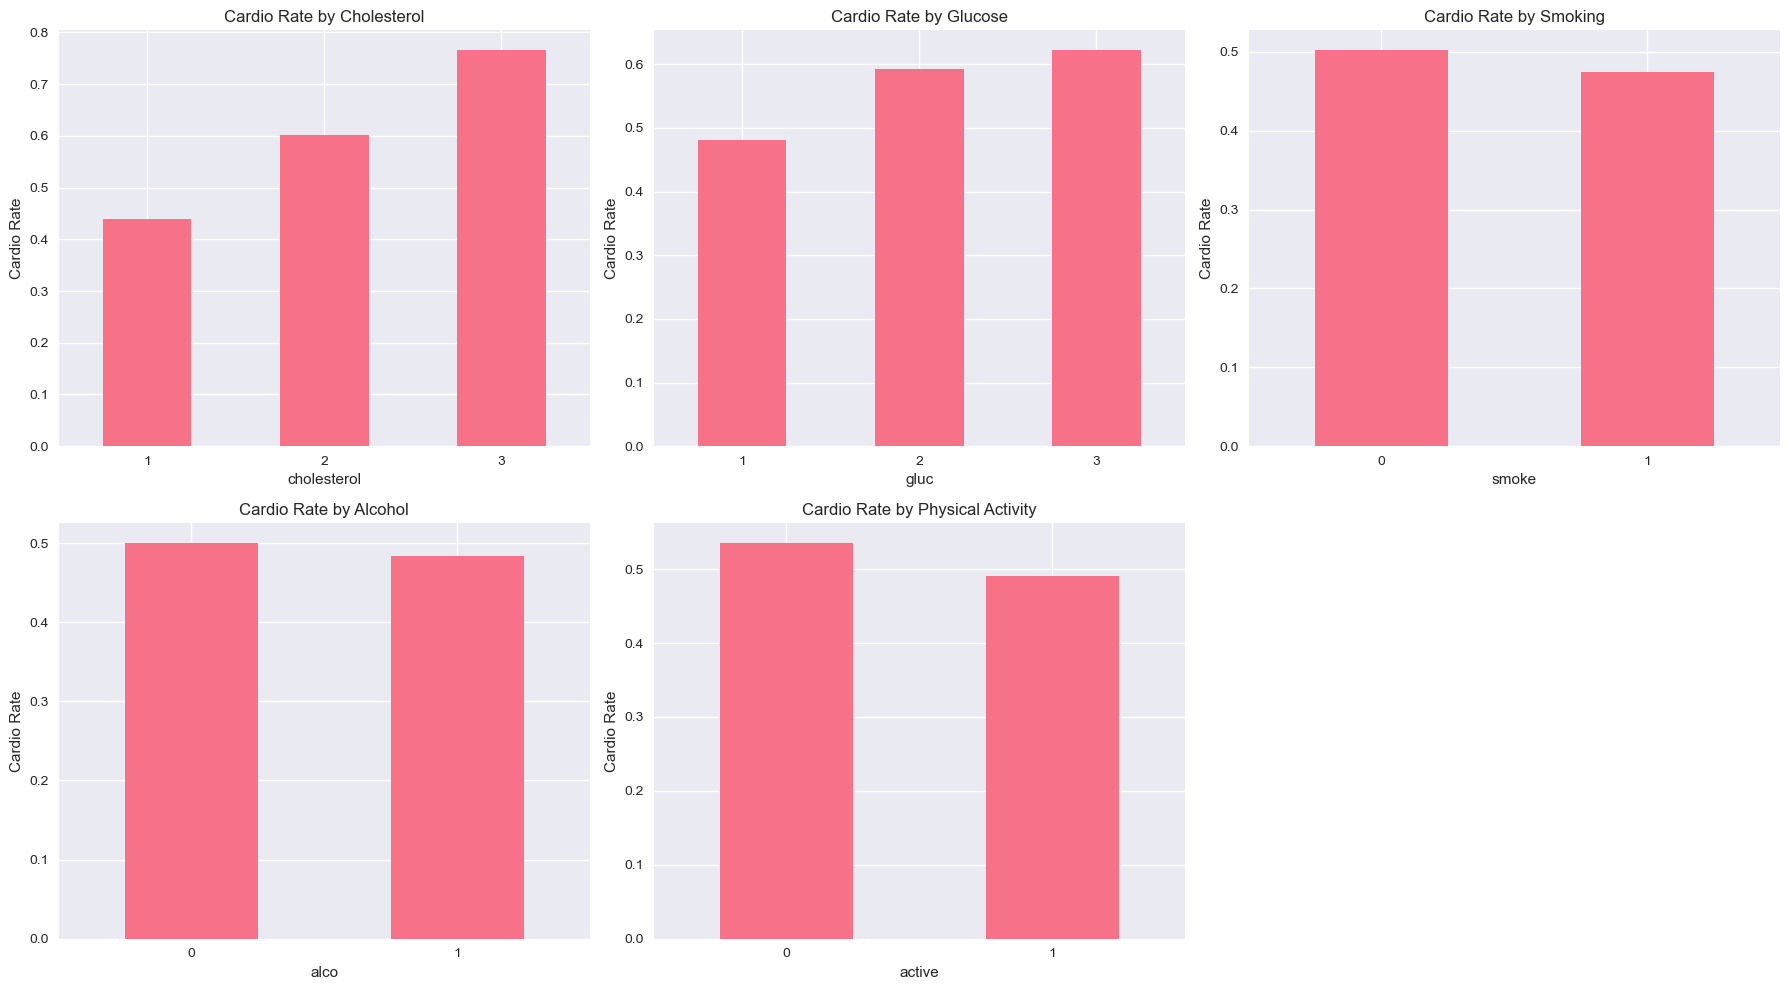

In [39]:
# Categorical features analysis
categorical_features = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']
feature_names = ['Cholesterol', 'Glucose', 'Smoking', 'Alcohol', 'Physical Activity']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (feature, name) in enumerate(zip(categorical_features, feature_names)):
    cardio_rate = df_processed.groupby(feature)['cardio'].mean()
    cardio_rate.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Cardio Rate by {name}')
    axes[i].set_ylabel('Cardio Rate')
    axes[i].tick_params(axis='x', rotation=0)

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

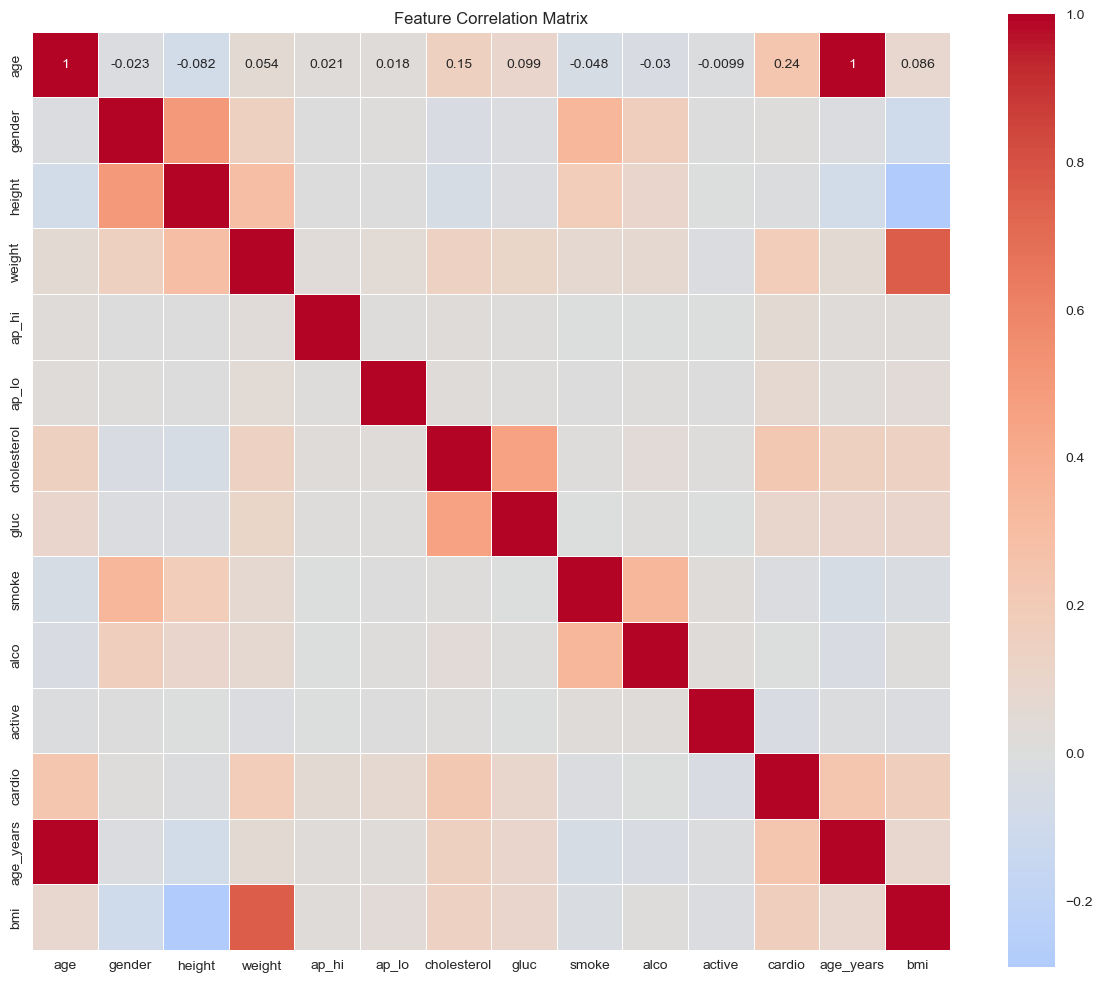

In [40]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                                   'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 
                                   'age_years', 'bmi']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Data Cleaning and Outlier Detection

In [41]:
# Check for unrealistic values
print("Checking for unrealistic values:")
print(f"Height range: {df_processed['height'].min()} - {df_processed['height'].max()}")
print(f"Weight range: {df_processed['weight'].min()} - {df_processed['weight'].max()}")
print(f"Systolic BP range: {df_processed['ap_hi'].min()} - {df_processed['ap_hi'].max()}")
print(f"Diastolic BP range: {df_processed['ap_lo'].min()} - {df_processed['ap_lo'].max()}")
print(f"BMI range: {df_processed['bmi'].min():.2f} - {df_processed['bmi'].max():.2f}")

# Remove unrealistic values
# Filter out extreme outliers
df_clean = df_processed[
    (df_processed['height'] >= 120) & (df_processed['height'] <= 220) &
    (df_processed['weight'] >= 30) & (df_processed['weight'] <= 200) &
    (df_processed['ap_hi'] >= 70) & (df_processed['ap_hi'] <= 250) &
    (df_processed['ap_lo'] >= 40) & (df_processed['ap_lo'] <= 150) &
    (df_processed['ap_hi'] > df_processed['ap_lo'])  # Systolic should be higher than diastolic
]

print(f"\nRows removed: {len(df_processed) - len(df_clean)}")
print(f"Remaining rows: {len(df_clean)}")

Checking for unrealistic values:
Height range: 55 - 250
Weight range: 10.0 - 200.0
Systolic BP range: -150 - 16020
Diastolic BP range: -70 - 11000
BMI range: 3.47 - 298.67

Rows removed: 1390
Remaining rows: 68610


## Feature Engineering and Model Preparation

In [42]:
# Select features for modeling
feature_columns = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                   'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']

X = df_clean[feature_columns]
y = df_clean['cardio']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nFeatures:")
for i, col in enumerate(feature_columns):
    print(f"{i+1}. {col}")

Feature matrix shape: (68610, 12)
Target vector shape: (68610,)

Features:
1. age_years
2. gender
3. height
4. weight
5. ap_hi
6. ap_lo
7. cholesterol
8. gluc
9. smoke
10. alco
11. active
12. bmi


In [43]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining target distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Training set shape: (54888, 12)
Test set shape: (13722, 12)

Training target distribution:
cardio
0    0.505302
1    0.494698
Name: proportion, dtype: float64

Test target distribution:
cardio
0    0.50532
1    0.49468
Name: proportion, dtype: float64


In [44]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print("Training set mean:", X_train_scaled.mean(axis=0).round(3))
print("Training set std:", X_train_scaled.std(axis=0).round(3))

Features scaled successfully!
Training set mean: [-0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0. -0.]
Training set std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Model Training and Evaluation

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


Training Logistic Regression...
Accuracy: 0.7294
Precision: 0.7526
Recall: 0.6749
F1-Score: 0.7116
AUC: 0.7919

Training Random Forest...
Accuracy: 0.7294
Precision: 0.7526
Recall: 0.6749
F1-Score: 0.7116
AUC: 0.7919

Training Random Forest...


Accuracy: 0.7094
Precision: 0.7072
Recall: 0.7042
F1-Score: 0.7057
AUC: 0.7684

Training Gradient Boosting...
Accuracy: 0.7356
Precision: 0.7480
Recall: 0.7021
F1-Score: 0.7243
AUC: 0.8009

Training SVM...
Accuracy: 0.7356
Precision: 0.7480
Recall: 0.7021
F1-Score: 0.7243
AUC: 0.8009

Training SVM...


In [ ]:
# Model comparison
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1-Score': [results['f1'] for results in model_results.values()],
    'AUC': [results['auc'] for results in model_results.values()]
})

print("Model Comparison:")
print(results_df.round(4))

# Find best model
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
print(f"\nBest model based on AUC: {best_model_name}")

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Logistic Regression    0.7294     0.7526  0.6749    0.7116  0.7919
1        Random Forest    0.7094     0.7072  0.7042    0.7057  0.7684
2    Gradient Boosting    0.7356     0.7480  0.7021    0.7243  0.8009
3                  SVM    0.7354     0.7580  0.6833    0.7187  0.7916

Best model based on AUC: Gradient Boosting


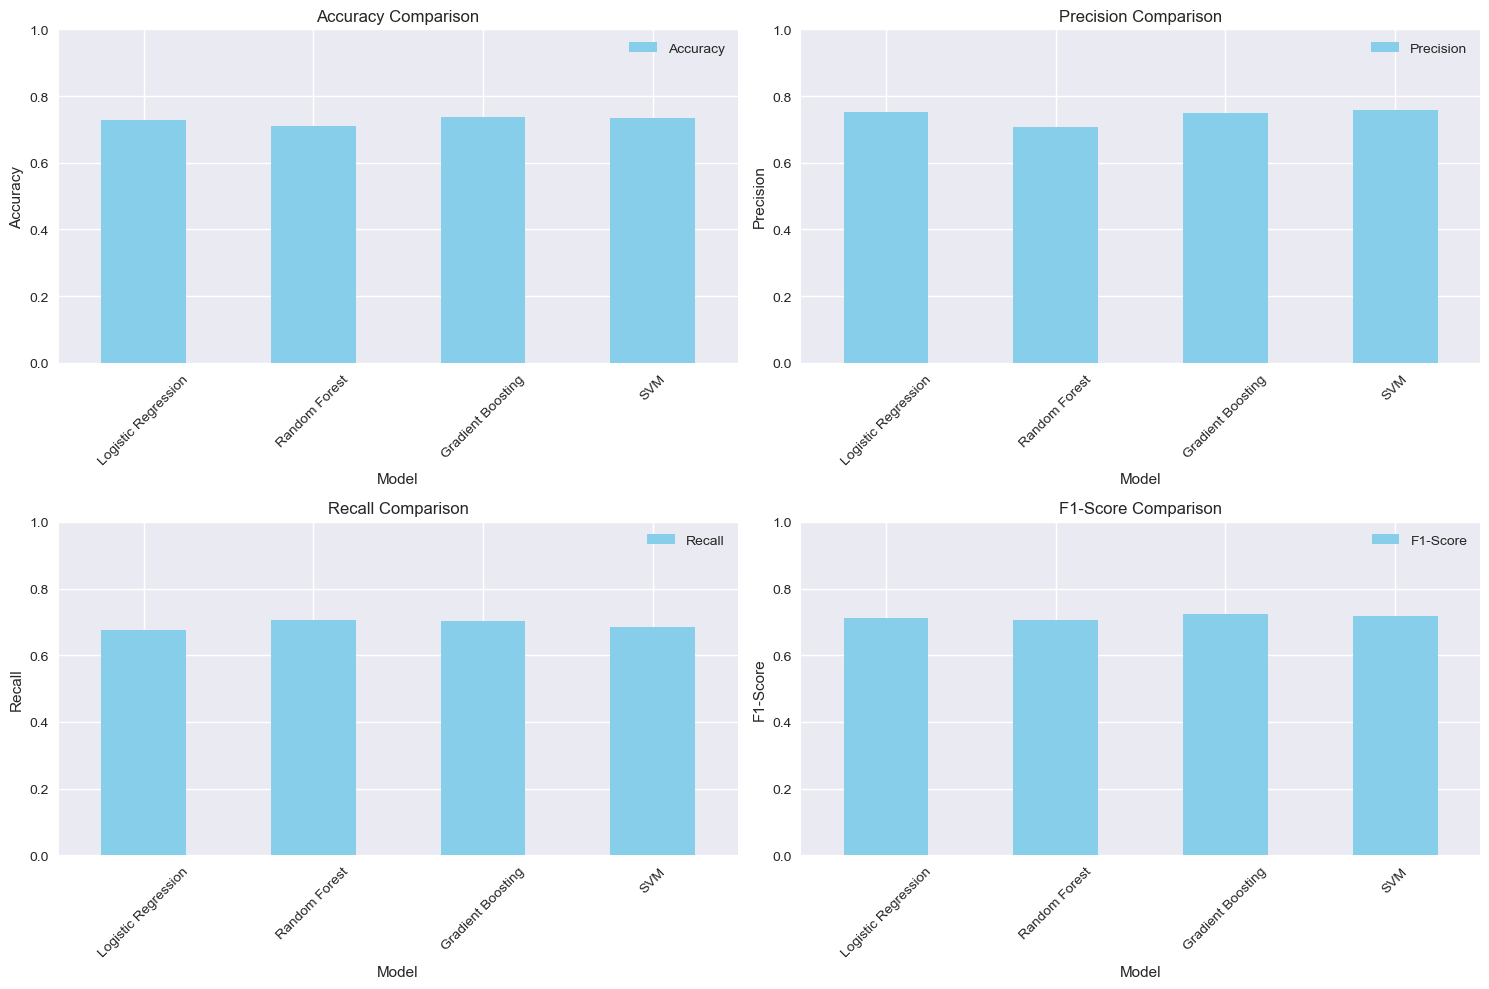

In [ ]:
# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    results_df.plot(x='Model', y=metric, kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

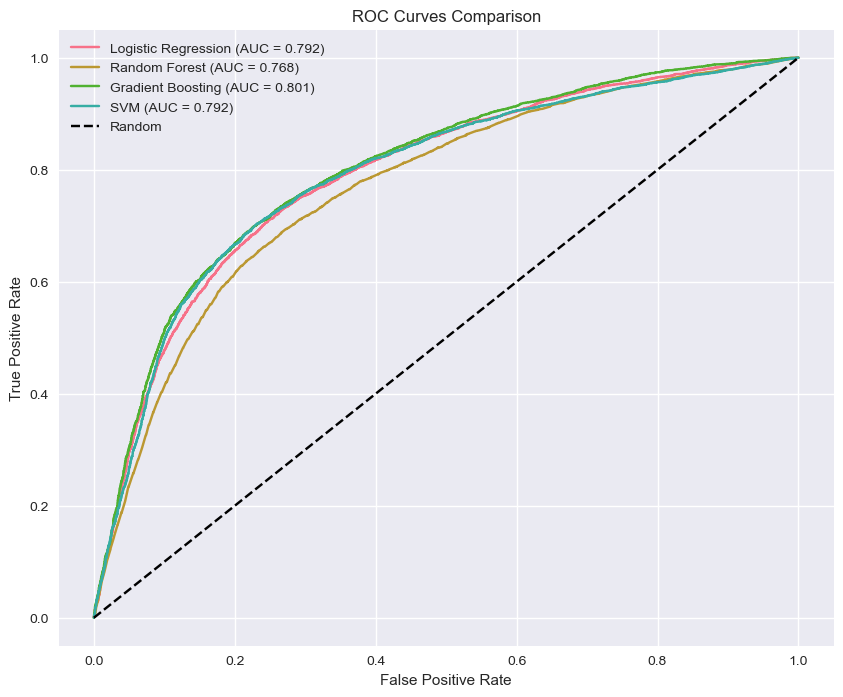

In [ ]:
# ROC Curves
plt.figure(figsize=(10, 8))

for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

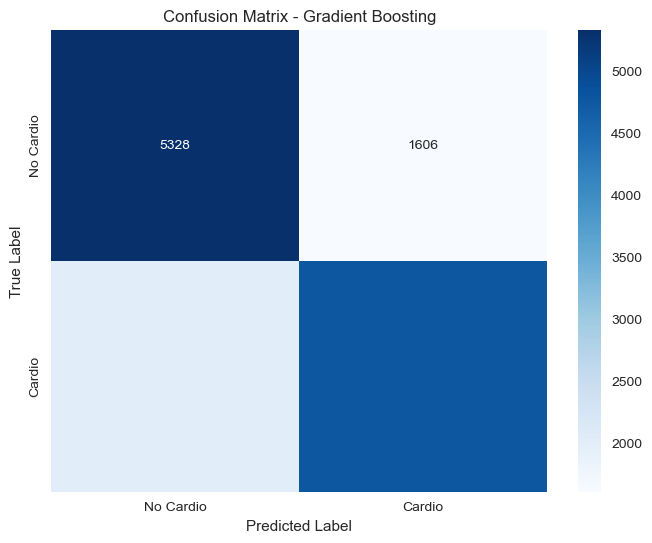


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

   No Cardio       0.72      0.77      0.75      6934
      Cardio       0.75      0.70      0.72      6788

    accuracy                           0.74     13722
   macro avg       0.74      0.74      0.74     13722
weighted avg       0.74      0.74      0.74     13722



In [ ]:
# Confusion Matrix for best model
best_model = model_results[best_model_name]['model']
best_predictions = model_results[best_model_name]['predictions']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cardio', 'Cardio'], 
            yticklabels=['No Cardio', 'Cardio'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions, 
                          target_names=['No Cardio', 'Cardio']))

## Feature Importance Analysis

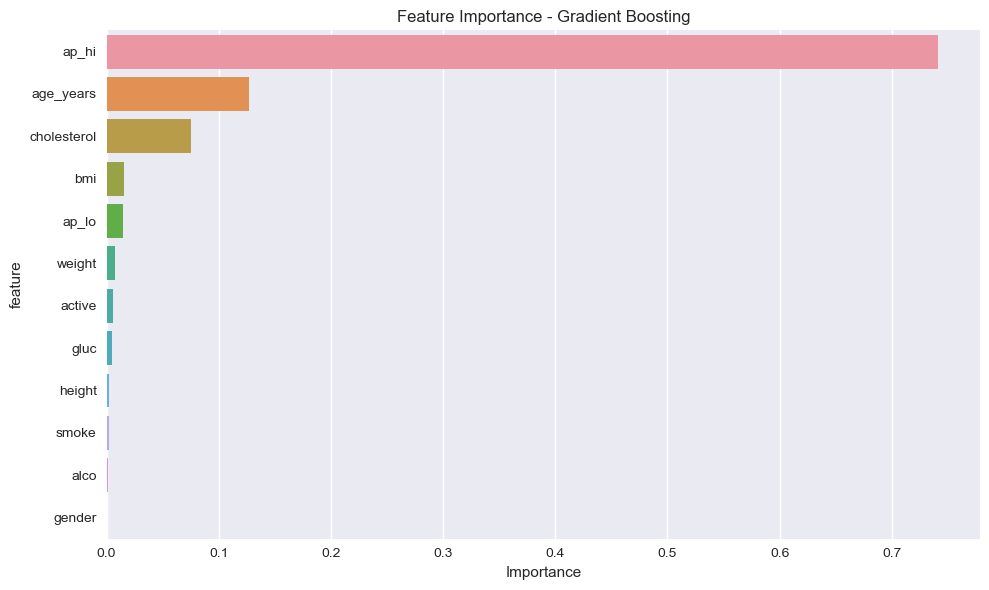

Top 5 Most Important Features:
        feature  importance
4         ap_hi    0.741562
0     age_years    0.127119
6   cholesterol    0.075603
11          bmi    0.015403
5         ap_lo    0.014656


In [ ]:
# Feature importance for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 5 Most Important Features:")
    print(feature_importance.head())
    
elif best_model_name == 'Logistic Regression':
    # For logistic regression, show coefficients
    coefficients = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': best_model.coef_[0]
    })
    coefficients['abs_coefficient'] = abs(coefficients['coefficient'])
    coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=coefficients, x='coefficient', y='feature')
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.xlabel('Coefficient')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print("Top 5 Most Important Features (by absolute coefficient):")
    print(coefficients[['feature', 'coefficient']].head())

## Model Optimization

In [ ]:
# Hyperparameter tuning for the best model
print(f"Optimizing {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                              param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5, 7]
    }
    
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                              param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    
    grid_search = GridSearchCV(LogisticRegression(random_state=42), 
                              param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

# Get the optimized model
optimized_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

Optimizing Gradient Boosting...
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation AUC: 0.8011
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation AUC: 0.8011


In [ ]:
# Evaluate optimized model
if best_model_name in ['Logistic Regression']:
    y_pred_opt = optimized_model.predict(X_test_scaled)
    y_pred_proba_opt = optimized_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_opt = optimized_model.predict(X_test)
    y_pred_proba_opt = optimized_model.predict_proba(X_test)[:, 1]

# Calculate optimized metrics
opt_accuracy = accuracy_score(y_test, y_pred_opt)
opt_precision = precision_score(y_test, y_pred_opt)
opt_recall = recall_score(y_test, y_pred_opt)
opt_f1 = f1_score(y_test, y_pred_opt)
opt_auc = roc_auc_score(y_test, y_pred_proba_opt)

print(f"\nOptimized {best_model_name} Performance:")
print(f"Accuracy: {opt_accuracy:.4f}")
print(f"Precision: {opt_precision:.4f}")
print(f"Recall: {opt_recall:.4f}")
print(f"F1-Score: {opt_f1:.4f}")
print(f"AUC: {opt_auc:.4f}")

# Compare with original model
print(f"\nImprovement over original model:")
print(f"AUC improvement: {opt_auc - model_results[best_model_name]['auc']:.4f}")


Optimized Gradient Boosting Performance:
Accuracy: 0.7347
Precision: 0.7535
Recall: 0.6892
F1-Score: 0.7199
AUC: 0.8013

Improvement over original model:
AUC improvement: 0.0004


## Save Models and Preprocessing Objects

In [ ]:
# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Save the optimized model using cloudpickle
model_filename = f'models/cardio_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    cloudpickle.dump(optimized_model, f)

# Save the scaler
scaler_filename = 'models/scaler.pkl'
with open(scaler_filename, 'wb') as f:
    cloudpickle.dump(scaler, f)

# Save feature columns
features_filename = 'models/feature_columns.pkl'
with open(features_filename, 'wb') as f:
    cloudpickle.dump(feature_columns, f)

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(optimized_model).__name__,
    'features': feature_columns,
    'performance': {
        'accuracy': opt_accuracy,
        'precision': opt_precision,
        'recall': opt_recall,
        'f1_score': opt_f1,
        'auc': opt_auc
    },
    'best_parameters': grid_search.best_params_,
    'requires_scaling': best_model_name in ['Logistic Regression', 'SVM']
}

metadata_filename = 'models/model_metadata.pkl'
with open(metadata_filename, 'wb') as f:
    cloudpickle.dump(model_metadata, f)

print(f"Models saved successfully!")
print(f"Model file: {model_filename}")
print(f"Scaler file: {scaler_filename}")
print(f"Features file: {features_filename}")
print(f"Metadata file: {metadata_filename}")

Models saved successfully!
Model file: models/cardio_model_gradient_boosting.pkl
Scaler file: models/scaler.pkl
Features file: models/feature_columns.pkl
Metadata file: models/model_metadata.pkl


## Model Testing and Validation

In [ ]:
# Test loading the saved model
print("Testing saved model...")

# Load the saved model
with open(model_filename, 'rb') as f:
    loaded_model = cloudpickle.load(f)

# Load the scaler
with open(scaler_filename, 'rb') as f:
    loaded_scaler = cloudpickle.load(f)

# Load feature columns
with open(features_filename, 'rb') as f:
    loaded_features = cloudpickle.load(f)

# Load metadata
with open(metadata_filename, 'rb') as f:
    loaded_metadata = cloudpickle.load(f)

print("All files loaded successfully!")
print(f"Model type: {loaded_metadata['model_type']}")
print(f"Requires scaling: {loaded_metadata['requires_scaling']}")
print(f"Features: {loaded_features}")

Testing saved model...
All files loaded successfully!
Model type: GradientBoostingClassifier
Requires scaling: False
Features: ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']
All files loaded successfully!
Model type: GradientBoostingClassifier
Requires scaling: False
Features: ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']


In [ ]:
# Test prediction with a sample
sample_data = X_test.iloc[:5].copy()
print("Sample data for prediction:")
print(sample_data)

# Make prediction
if loaded_metadata['requires_scaling']:
    sample_scaled = loaded_scaler.transform(sample_data)
    predictions = loaded_model.predict(sample_scaled)
    probabilities = loaded_model.predict_proba(sample_scaled)[:, 1]
else:
    predictions = loaded_model.predict(sample_data)
    probabilities = loaded_model.predict_proba(sample_data)[:, 1]

print("\nPredictions:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Sample {i+1}: Prediction = {pred}, Probability = {prob:.3f}")

print("\nActual values:")
print(y_test.iloc[:5].values)

print("\nModel testing completed successfully!")

Sample data for prediction:
       age_years  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
38173         49       1     156    55.0    120     80            1     1   
56721         50       2     167    85.0    130     80            2     1   
31410         46       2     174    84.0    120     80            1     1   
65465         49       2     171    77.0    120     90            1     1   
36388         55       2     167    72.0    120     70            2     1   

       smoke  alco  active        bmi  
38173      0     0       1  22.600263  
56721      1     1       1  30.477966  
31410      0     0       1  27.744748  
65465      0     0       1  26.332889  
36388      0     0       1  25.816630  

Predictions:
Sample 1: Prediction = 0, Probability = 0.215
Sample 2: Prediction = 0, Probability = 0.460
Sample 3: Prediction = 0, Probability = 0.269
Sample 4: Prediction = 0, Probability = 0.253
Sample 5: Prediction = 0, Probability = 0.373

Actual values:
[1 1 0 0 

## Summary and Insights

In [ ]:
print("=" * 50)
print("CARDIOVASCULAR DISEASE PREDICTION MODEL SUMMARY")
print("=" * 50)

print(f"\nDataset Information:")
print(f"- Total samples: {len(df_clean):,}")
print(f"- Features used: {len(feature_columns)}")
print(f"- Target distribution: {(1-y.mean())*100:.1f}% No Cardio, {y.mean()*100:.1f}% Cardio")

print(f"\nBest Model: {best_model_name}")
print(f"- Accuracy: {opt_accuracy:.3f}")
print(f"- Precision: {opt_precision:.3f}")
print(f"- Recall: {opt_recall:.3f}")
print(f"- F1-Score: {opt_f1:.3f}")
print(f"- AUC-ROC: {opt_auc:.3f}")

print(f"\nKey Insights from EDA:")
print(f"- Age is a strong predictor (older people have higher risk)")
print(f"- Blood pressure (both systolic and diastolic) strongly correlates with cardio risk")
print(f"- BMI and cholesterol levels are important factors")
print(f"- Gender differences exist in cardiovascular disease prevalence")

print(f"\nFiles Generated:")
print(f"- Model: {model_filename}")
print(f"- Scaler: {scaler_filename}")
print(f"- Features: {features_filename}")
print(f"- Metadata: {metadata_filename}")

print(f"\nReady for Streamlit deployment!")
print("=" * 50)

CARDIOVASCULAR DISEASE PREDICTION MODEL SUMMARY

Dataset Information:
- Total samples: 68,610
- Features used: 12
- Target distribution: 50.5% No Cardio, 49.5% Cardio

Best Model: Gradient Boosting
- Accuracy: 0.735
- Precision: 0.754
- Recall: 0.689
- F1-Score: 0.720
- AUC-ROC: 0.801

Key Insights from EDA:
- Age is a strong predictor (older people have higher risk)
- Blood pressure (both systolic and diastolic) strongly correlates with cardio risk
- BMI and cholesterol levels are important factors
- Gender differences exist in cardiovascular disease prevalence

Files Generated:
- Model: models/cardio_model_gradient_boosting.pkl
- Scaler: models/scaler.pkl
- Features: models/feature_columns.pkl
- Metadata: models/model_metadata.pkl

Ready for Streamlit deployment!
